In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from propagation import plasma
from lens import profile
from lens import bessel
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate

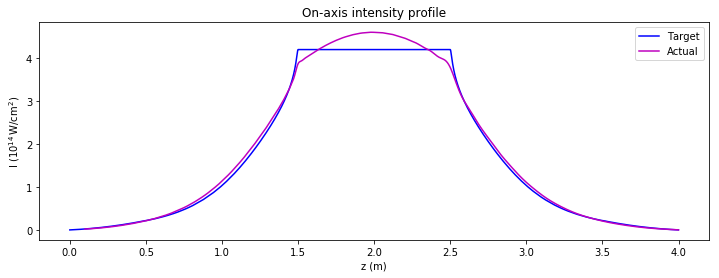

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# Calculate the electric field
params = {'N' : 1000,
          'M' : 1000,
          'R' : 0.3e3,
          'lam' : 0.8,
          'rmax' : 10e3
         }
Ez = ionization.field_from_intensity(I)
rm, E = bessel.uniform_bessel(params, Ez, z)
E = E*8.15e6

zFres = np.linspace(1e5, 4e6, 1000)
Efield = interp1d(rm, E)
r = np.linspace(0, 10e3, 10000)
E0 = Efield(r)

e = laser.fresnel_axis(E0, r, zFres, params['lam'])
IFres = ionization.intensity_from_field(abs(e))

plt.figure(figsize={12, 4})
plt.plot(z[0:4000]/1e6, I[0:4000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

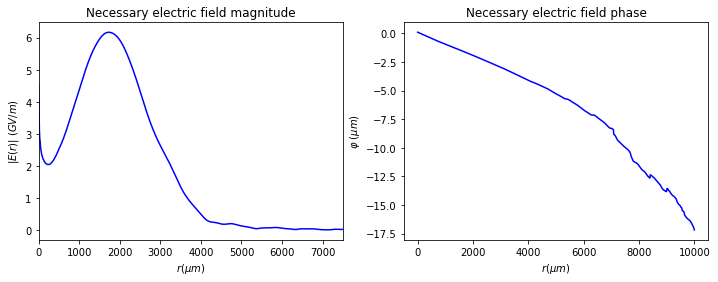

In [3]:
k = 2*np.pi/params['lam']
phi = np.unwrap(np.angle(E))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title(r'Necessary electric field magnitude')
plt.xlim([0, 7500])

plt.subplot(122)
plt.plot(rm, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

In [18]:
# Propagation through 3 axicon lenses
w0 = 2e3 # Initial Gaussian width
L = 10e4 # Spacing between axicons in telescope
beta = 2.273  # Deflection angle, 5.0 deg physical

def Efunc(x, y):
    # Input Gaussian beam
    r2 = x**2 + y**2
    E0 = np.exp(-r2 / params['w0']**2)
    # Axicon lens
    beta = np.radians(params['beta'])
    T0 = np.exp(-1j*2*np.pi*beta*np.sqrt(r2)/params['lam'])
    # Initial electric field
    return E0 * T0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**10,
          'Nz' : 2**7,
          'X' : 10e3,
          'Y' : 10e3,
          'Z' : L,
          'E0' : ionization.field_from_intensity(1.0),
          'lam' : 0.8,
          'n' : 1.0,
          'w0' : w0,
          'beta' : beta,
          'xlim' : [-5, 5],
          'crosslim' : [-5, 5]
          }

path = '/media/robert/Data_Storage/Data/Optics/TripleAxicon/'

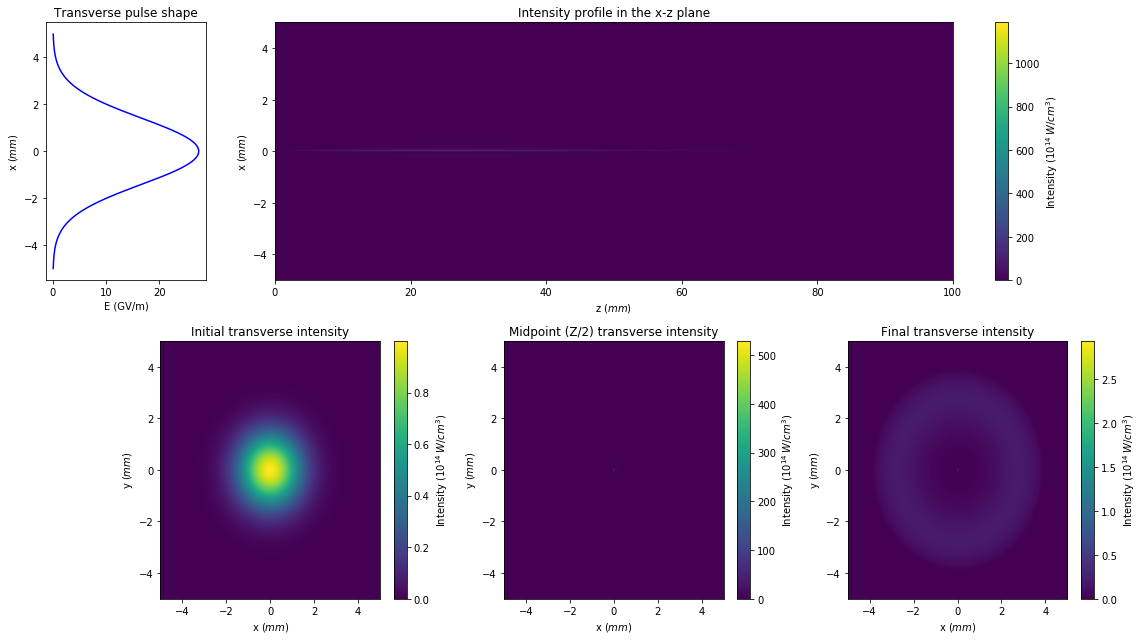

In [19]:
directory = 'Telescope'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])